# RL Portfolio Optimization — Robust Subset Testing

This notebook tests the RL-optimized portfolio against equal-weight baseline using **robust inference techniques** to improve RL's performance without retraining.

**Robust Inference Techniques Applied:**
1. **Start-step ensemble**: Run policy from multiple start indices, aggregate weights
2. **Last-K smoothed weights**: Use median of last K steps' smoothed weights
3. **Cap + Floor**: Limit max/min per-asset allocation to reduce concentration
4. **Softmax temperature**: Flatten extreme allocations

**Evaluation Improvements:**
- `n_paths=2000` for reliable tail metrics
- `noise="block_bootstrap"` to preserve temporal dependence

**Metrics compared:**
- Mean Return
- Sharpe Ratio
- VaR (95%)
- CVaR (95%)

## 1. Setup and Imports

In [17]:
import sys
from pathlib import Path
import itertools
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))
sys.path.insert(0, str(project_root / "scripts"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Project imports
from input_parser import CapitalConfig
from scripts.compare_portfolio_mc import (
    run_portfolio_comparison,
    PortfolioComparison,
)
from stable_baselines3 import PPO
from portfolio_env import PortfolioEnv

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✓ Imports successful")

✓ Imports successful


## 2. Load Training Data and Model

In [18]:
# Load the TRAINING price data (same data the model was trained on)
RL_PRICE_CSV = project_root / 'data' / 'rl_training_price_data_india.csv'
price_df_full = pd.read_csv(RL_PRICE_CSV, index_col=0, parse_dates=True)

# All available tickers from training data
ALL_TICKERS = list(price_df_full.columns)
print(f"Total tickers in training data: {len(ALL_TICKERS)}")
print(f"Tickers: {ALL_TICKERS}")
print(f"Date range: {price_df_full.index[0]} to {price_df_full.index[-1]}")
print(f"Total rows: {len(price_df_full)}")

Total tickers in training data: 25
Tickers: ['HDFCBANK.NS', 'ICICIBANK.NS', 'SBIN.NS', 'AXISBANK.NS', 'KOTAKBANK.NS', 'TCS.NS', 'INFY.NS', 'HCLTECH.NS', 'WIPRO.NS', 'TECHM.NS', 'RELIANCE.NS', 'LT.NS', 'ONGC.NS', 'NTPC.NS', 'HINDUNILVR.NS', 'ITC.NS', 'NESTLEIND.NS', 'ASIANPAINT.NS', 'MARUTI.NS', 'TATAMOTORS.NS', 'M&M.NS', 'SUNPHARMA.NS', 'DRREDDY.NS', 'CIPLA.NS', 'BHARTIARTL.NS']
Date range: 2018-01-01 00:00:00 to 2021-10-29 00:00:00
Total rows: 1000


In [19]:
# Load the trained RL model
MODEL_PATH = None
candidates = []
models_dir = project_root / 'models'
archive_dir = project_root / 'logs' / 'archive'

if models_dir.exists():
    candidates += sorted(models_dir.glob('*.zip'), key=lambda p: p.stat().st_mtime, reverse=True)
if archive_dir.exists():
    candidates += sorted(archive_dir.glob('*.zip'), key=lambda p: p.stat().st_mtime, reverse=True)

candidates = [p for p in candidates if 'ppo' in p.name.lower() or 'model' in p.name.lower()]

if candidates:
    MODEL_PATH = candidates[0]
    print(f"Loading model: {MODEL_PATH}")
    model = PPO.load(MODEL_PATH)
    print(f"✓ Model loaded successfully")
else:
    raise FileNotFoundError("No model found in 'models/' or 'logs/archive/'")

Loading model: c:\Users\Atharva Srivastava\Downloads\anndl\models\ppo_model.zip
✓ Model loaded successfully


## 3. Define Robust Inference Parameters

In [20]:
# =============================================================================
# ROBUST INFERENCE CONFIGURATION
# =============================================================================

ROBUST_CONFIG = {
    # Start-step ensemble: run from multiple start offsets and aggregate
    "use_start_ensemble": True,
    "start_offsets": [-4, -3, -2, -1, 0],  # Offsets from default end position
    "ensemble_agg": "median",  # "median" or "mean"
    
    # Last-K smoothed weights: use median of last K steps' weights
    "use_last_k_smoothing": True,
    "last_k": 5,  # Number of steps to aggregate
    
    # Cap and floor: limit per-asset allocation
    "use_cap_floor": True,
    "cap": 0.15,   # Max 30% per asset
    "floor": 0.02, # Min 1% per asset (only if originally > 0)
    
    # Softmax temperature: flatten extreme allocations
    "use_softmax_temp": True,  # Disabled by default, cap+floor usually sufficient
    "temperature": 2.0,
    
    # Monte Carlo evaluation parameters
    "n_paths": 2000,  # Increased for reliable tail metrics
    "noise": "block_bootstrap",  # Preserves temporal dependence
    "n_steps": 252,
}

print("Robust Inference Configuration:")
for key, value in ROBUST_CONFIG.items():
    print(f"  {key}: {value}")

Robust Inference Configuration:
  use_start_ensemble: True
  start_offsets: [-4, -3, -2, -1, 0]
  ensemble_agg: median
  use_last_k_smoothing: True
  last_k: 5
  use_cap_floor: True
  cap: 0.15
  floor: 0.02
  use_softmax_temp: True
  temperature: 2.0
  n_paths: 2000
  noise: block_bootstrap
  n_steps: 252


## 4. Define Ticker Subsets to Test

In [21]:
# =============================================================================
# DEFINE TICKER SUBSETS TO TEST
# =============================================================================

TICKER_SUBSETS = {
    # Banking sector
    "Banks": ["HDFCBANK.NS", "ICICIBANK.NS", "SBIN.NS", "AXISBANK.NS", "KOTAKBANK.NS"],
    
    # IT sector
    "IT": ["TCS.NS", "INFY.NS", "HCLTECH.NS", "WIPRO.NS", "TECHM.NS"],
    
    # Pharma sector
    "Pharma": ["SUNPHARMA.NS", "DRREDDY.NS", "CIPLA.NS"],
    
    # Consumer/FMCG
    "Consumer": ["HINDUNILVR.NS", "ITC.NS", "NESTLEIND.NS", "ASIANPAINT.NS"],
    
    # Auto sector
    "Auto": ["MARUTI.NS", "TATAMOTORS.NS", "M&M.NS"],
    
    # Energy/Infrastructure
    "Energy_Infra": ["RELIANCE.NS", "LT.NS", "ONGC.NS", "NTPC.NS"],
    
    # Mixed: Banks + IT
    "Banks_IT": ["HDFCBANK.NS", "ICICIBANK.NS", "TCS.NS", "INFY.NS", "WIPRO.NS"],
    
    # Mixed: Diversified 6
    "Diversified_6": ["HDFCBANK.NS", "TCS.NS", "RELIANCE.NS", "SUNPHARMA.NS", "MARUTI.NS", "ITC.NS"],
    
    # Mixed: Top 10 by typical market cap
    "Top_10": ["RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "ICICIBANK.NS", "INFY.NS", 
               "HINDUNILVR.NS", "ITC.NS", "SBIN.NS", "BHARTIARTL.NS", "KOTAKBANK.NS"],
    
    # Small subset: 3 tickers
    "Small_3": ["HDFCBANK.NS", "TCS.NS", "RELIANCE.NS"],
    
    # Medium subset: 8 tickers
    "Medium_8": ["HDFCBANK.NS", "ICICIBANK.NS", "TCS.NS", "INFY.NS", 
                 "RELIANCE.NS", "SUNPHARMA.NS", "MARUTI.NS", "HINDUNILVR.NS"],
    
    # Large subset: 15 tickers
    "Large_15": ["HDFCBANK.NS", "ICICIBANK.NS", "SBIN.NS", "AXISBANK.NS", "KOTAKBANK.NS",
                 "TCS.NS", "INFY.NS", "HCLTECH.NS", "RELIANCE.NS", "LT.NS",
                 "HINDUNILVR.NS", "ITC.NS", "SUNPHARMA.NS", "MARUTI.NS", "BHARTIARTL.NS"],
    
    # All 25 tickers
    "All_25": ALL_TICKERS,
}

print(f"Defined {len(TICKER_SUBSETS)} ticker subsets to test:")
for name, tickers in TICKER_SUBSETS.items():
    print(f"  {name}: {len(tickers)} tickers")

Defined 13 ticker subsets to test:
  Banks: 5 tickers
  IT: 5 tickers
  Pharma: 3 tickers
  Consumer: 4 tickers
  Auto: 3 tickers
  Energy_Infra: 4 tickers
  Banks_IT: 5 tickers
  Diversified_6: 6 tickers
  Top_10: 10 tickers
  Small_3: 3 tickers
  Medium_8: 8 tickers
  Large_15: 15 tickers
  All_25: 25 tickers


## 5. Robust Weight Extraction Functions

In [22]:
def apply_cap_floor(weights: np.ndarray, cap: float, floor: float) -> np.ndarray:
    """
    Apply cap and floor to weights, then renormalize.
    
    Args:
        weights: Array of portfolio weights (should sum to 1)
        cap: Maximum allowed weight per asset
        floor: Minimum weight for assets that have non-zero allocation
    
    Returns:
        Adjusted and renormalized weights
    """
    adjusted = weights.copy()
    
    # Apply floor only to assets with positive weight
    positive_mask = adjusted > 0
    adjusted[positive_mask] = np.maximum(adjusted[positive_mask], floor)
    
    # Apply cap
    adjusted = np.minimum(adjusted, cap)
    
    # Renormalize
    if adjusted.sum() > 0:
        adjusted = adjusted / adjusted.sum()
    else:
        # Fallback to equal weight if all zeros
        adjusted = np.ones_like(adjusted) / len(adjusted)
    
    return adjusted


def apply_softmax_temperature(weights: np.ndarray, temperature: float) -> np.ndarray:
    """
    Apply softmax with temperature to flatten extreme allocations.
    
    Higher temperature -> flatter distribution.
    
    Args:
        weights: Array of positive weights
        temperature: Temperature parameter (T > 1 flattens, T < 1 sharpens)
    
    Returns:
        Temperature-adjusted weights
    """
    # Use log of weights as "logits" (add small epsilon for stability)
    eps = 1e-8
    logits = np.log(weights + eps)
    
    # Apply temperature
    scaled_logits = logits / temperature
    
    # Softmax
    exp_logits = np.exp(scaled_logits - scaled_logits.max())  # Numerical stability
    return exp_logits / exp_logits.sum()


def run_single_rollout(
    price_df: pd.DataFrame,
    model: PPO,
    n_assets: int,
    n_steps: int,
    seed: int,
    start_step: int = None,
    collect_smoothed: bool = True,
) -> tuple:
    """
    Run a single deterministic rollout and collect weights.
    
    Returns:
        (final_action, list_of_smoothed_weights_per_step)
    """
    # Create a fresh env for each rollout with specific start_step
    env = PortfolioEnv(
        n_assets=n_assets,
        price_df=price_df,
        transaction_cost=0.001,
        reward_alpha=0.0,
        window=20,
        start_step=start_step,  # Pass start_step to constructor
    )
    
    obs, info = env.reset(seed=seed)
    
    smoothed_weights_history = []
    final_action = None
    
    for step_idx in range(n_steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        
        final_action = action
        
        # Collect smoothed weights if available
        if collect_smoothed and "smoothed_weights" in info:
            smoothed_weights_history.append(info["smoothed_weights"].copy())
        else:
            # Use normalized action as fallback
            normalized = action / action.sum() if action.sum() > 0 else np.ones_like(action) / len(action)
            smoothed_weights_history.append(normalized)
        
        if terminated or truncated:
            break
    
    return final_action, smoothed_weights_history


def get_robust_weights(
    price_df: pd.DataFrame,
    model: PPO,
    all_tickers: list,
    config: dict,
    seed: int = 42,
) -> np.ndarray:
    """
    Extract robust RL weights using configured techniques.
    
    Applies:
    1. Start-step ensemble (if enabled)
    2. Last-K smoothing (if enabled)
    3. Cap + Floor (if enabled)
    4. Softmax temperature (if enabled)
    
    Returns:
        Robust weight array for all assets
    """
    n_assets = len(all_tickers)
    
    # Determine rollout parameters
    window = 20
    max_steps = len(price_df) - window - 2
    n_rollout_steps = min(50, max_steps)
    
    all_weight_sets = []
    
    # --- Start-step ensemble ---
    if config.get("use_start_ensemble", False):
        start_offsets = config.get("start_offsets", [0])
        # Base start is such that we have room for n_rollout_steps
        base_start = max(window, max_steps - n_rollout_steps)
        
        for offset in start_offsets:
            start_step = max(window, base_start + offset)
            final_action, smoothed_history = run_single_rollout(
                price_df, model, n_assets, n_rollout_steps, seed, start_step=start_step
            )
            
            # --- Last-K smoothing ---
            if config.get("use_last_k_smoothing", False) and len(smoothed_history) > 0:
                last_k = config.get("last_k", 5)
                last_k_weights = smoothed_history[-last_k:]
                weights = np.median(last_k_weights, axis=0)
            else:
                # Use final action
                weights = final_action / final_action.sum() if final_action.sum() > 0 else np.ones(n_assets) / n_assets
            
            all_weight_sets.append(weights)
    else:
        # Single rollout without ensemble
        final_action, smoothed_history = run_single_rollout(
            price_df, model, n_assets, n_rollout_steps, seed
        )
        
        if config.get("use_last_k_smoothing", False) and len(smoothed_history) > 0:
            last_k = config.get("last_k", 5)
            last_k_weights = smoothed_history[-last_k:]
            weights = np.median(last_k_weights, axis=0)
        else:
            weights = final_action / final_action.sum() if final_action.sum() > 0 else np.ones(n_assets) / n_assets
        
        all_weight_sets.append(weights)
    
    # --- Aggregate across ensemble ---
    if len(all_weight_sets) > 1:
        agg_method = config.get("ensemble_agg", "median")
        if agg_method == "median":
            weights = np.median(all_weight_sets, axis=0)
        else:
            weights = np.mean(all_weight_sets, axis=0)
    else:
        weights = all_weight_sets[0]
    
    # Ensure positive and normalized
    weights = np.clip(weights, 0, None)
    weights = weights / weights.sum() if weights.sum() > 0 else np.ones(n_assets) / n_assets
    
    # --- Apply softmax temperature ---
    if config.get("use_softmax_temp", False):
        temperature = config.get("temperature", 2.0)
        weights = apply_softmax_temperature(weights, temperature)
    
    # --- Apply cap + floor ---
    if config.get("use_cap_floor", False):
        cap = config.get("cap", 0.30)
        floor = config.get("floor", 0.01)
        weights = apply_cap_floor(weights, cap, floor)
    
    return weights


print("✓ Robust weight extraction functions defined")

✓ Robust weight extraction functions defined


## 6. Define Robust Evaluation Function

In [23]:
def evaluate_subset_robust(
    subset_name: str,
    tickers: list,
    price_df_full: pd.DataFrame,
    model: PPO,
    all_tickers: list,
    config: dict,
    total_capital: float = 50000,
    reserved_cash: float = 10000,
    seed: int = 42,
) -> dict:
    """
    Evaluate RL vs equal-weight for a given ticker subset using robust inference.
    
    The model was trained on ALL 25 tickers, so we:
    1. Run robust weight extraction on full 25-ticker environment
    2. Extract weights for the subset tickers only
    3. Renormalize those weights
    4. Run MC comparison on the subset with improved parameters
    
    Returns dict with comparison metrics.
    """
    n_subset_assets = len(tickers)
    
    # Filter price data to subset tickers for MC simulation
    price_df_subset = price_df_full[tickers].dropna()
    
    # Capital config
    capital_config = CapitalConfig(total_capital, reserved_cash)
    
    # Equal-weight baseline for subset
    current_weights = {t: 1.0 / n_subset_assets for t in tickers}
    
    # --- Get robust RL weights for FULL universe ---
    full_rl_weights = get_robust_weights(
        price_df=price_df_full,
        model=model,
        all_tickers=all_tickers,
        config=config,
        seed=seed,
    )
    
    full_rl_weights_dict = {t: float(w) for t, w in zip(all_tickers, full_rl_weights)}
    
    # Extract weights for SUBSET tickers only and renormalize
    subset_weights = {t: full_rl_weights_dict[t] for t in tickers}
    total_subset_weight = sum(subset_weights.values())
    
    if total_subset_weight > 0:
        target_weights = {t: w / total_subset_weight for t, w in subset_weights.items()}
    else:
        # Fallback to equal weight if subset has no allocation
        target_weights = {t: 1.0 / n_subset_assets for t in tickers}
    
    # --- Run Monte Carlo comparison on SUBSET with improved parameters ---
    comparison = run_portfolio_comparison(
        price_df=price_df_subset,
        current_weights=current_weights,
        target_weights=target_weights,
        initial_capital=capital_config.investable_capital,
        n_paths=config.get("n_paths", 2000),
        n_steps=config.get("n_steps", 252),
        seed=seed,
        noise=config.get("noise", "block_bootstrap"),
    )
    
    # --- Collect results ---
    result = {
        "subset_name": subset_name,
        "n_tickers": n_subset_assets,
        "tickers": tickers,
        
        # Current (equal-weight) metrics
        "current_mean_return": comparison.current.mean_return,
        "current_std_return": comparison.current.std_return,
        "current_sharpe": comparison.sharpe_current,
        "current_var_95": comparison.current.var_95,
        "current_cvar_95": comparison.current.cvar_95,
        
        # RL-optimized metrics
        "rl_mean_return": comparison.optimized.mean_return,
        "rl_std_return": comparison.optimized.std_return,
        "rl_sharpe": comparison.sharpe_optimized,
        "rl_var_95": comparison.optimized.var_95,
        "rl_cvar_95": comparison.optimized.cvar_95,
        
        # Comparison metrics
        "return_improvement": comparison.return_improvement,
        "var_reduction": comparison.risk_reduction_var95,
        "cvar_reduction": comparison.risk_reduction_cvar95,
        
        # RL wins (True if RL is better)
        "rl_wins_return": comparison.optimized.mean_return > comparison.current.mean_return,
        "rl_wins_sharpe": comparison.sharpe_optimized > comparison.sharpe_current,
        "rl_wins_var": comparison.optimized.var_95 > comparison.current.var_95,
        "rl_wins_cvar": comparison.optimized.cvar_95 > comparison.current.cvar_95,
        
        # Store weights
        "current_weights": current_weights,
        "target_weights": target_weights,
    }
    
    return result


print("✓ Robust evaluation function defined")

✓ Robust evaluation function defined


## 7. Run Evaluation on All Subsets

In [24]:
# Run evaluation on all subsets
results = []

print(f"Starting ROBUST evaluation of {len(TICKER_SUBSETS)} subsets...")
print(f"Config: n_paths={ROBUST_CONFIG['n_paths']}, noise={ROBUST_CONFIG['noise']}")
print(f"        start_ensemble={ROBUST_CONFIG['use_start_ensemble']}, last_k={ROBUST_CONFIG['last_k']}, cap={ROBUST_CONFIG['cap']}")
print("\n" + "="*80)

for idx, (subset_name, tickers) in enumerate(TICKER_SUBSETS.items(), 1):
    print(f"[{idx}/{len(TICKER_SUBSETS)}] Evaluating {subset_name} ({len(tickers)} tickers)...", end=" ")
    
    try:
        result = evaluate_subset_robust(
            subset_name=subset_name,
            tickers=tickers,
            price_df_full=price_df_full,
            model=model,
            all_tickers=ALL_TICKERS,
            config=ROBUST_CONFIG,
            total_capital=50000,
            reserved_cash=10000,
            seed=42,
        )
        results.append(result)
        
        # Count wins
        wins = sum([
            result["rl_wins_return"],
            result["rl_wins_sharpe"],
            result["rl_wins_var"],
            result["rl_wins_cvar"],
        ])
        print(f"RL wins {wins}/4 metrics ✓")
        
    except Exception as e:
        print(f"ERROR - {str(e)[:60]}")
        import traceback
        traceback.print_exc()
        results.append({
            "subset_name": subset_name,
            "n_tickers": len(tickers),
            "error": str(e)
        })

print("="*80)
print(f"\nCompleted evaluation of {len([r for r in results if 'error' not in r])} subsets")

Starting ROBUST evaluation of 13 subsets...
Config: n_paths=2000, noise=block_bootstrap
        start_ensemble=True, last_k=5, cap=0.15

[1/13] Evaluating Banks (5 tickers)... RL wins 4/4 metrics ✓
[2/13] Evaluating IT (5 tickers)... RL wins 1/4 metrics ✓
[3/13] Evaluating Pharma (3 tickers)... RL wins 2/4 metrics ✓
[4/13] Evaluating Consumer (4 tickers)... RL wins 3/4 metrics ✓
[5/13] Evaluating Auto (3 tickers)... RL wins 0/4 metrics ✓
[6/13] Evaluating Energy_Infra (4 tickers)... RL wins 0/4 metrics ✓
[7/13] Evaluating Banks_IT (5 tickers)... RL wins 3/4 metrics ✓
[8/13] Evaluating Diversified_6 (6 tickers)... RL wins 1/4 metrics ✓
[9/13] Evaluating Top_10 (10 tickers)... RL wins 3/4 metrics ✓
[10/13] Evaluating Small_3 (3 tickers)... RL wins 0/4 metrics ✓
[11/13] Evaluating Medium_8 (8 tickers)... RL wins 4/4 metrics ✓
[12/13] Evaluating Large_15 (15 tickers)... RL wins 4/4 metrics ✓
[13/13] Evaluating All_25 (25 tickers)... RL wins 1/4 metrics ✓

Completed evaluation of 13 subsets

## 8. Results Summary

In [25]:
# Create results DataFrame
results_df = pd.DataFrame(results)

# Filter out errors if any
if 'error' in results_df.columns:
    valid_results = results_df[results_df['error'].isna()].copy()
else:
    valid_results = results_df.copy()

# Summary table
summary_cols = [
    "subset_name", "n_tickers",
    "current_mean_return", "rl_mean_return", "return_improvement", "rl_wins_return",
    "current_sharpe", "rl_sharpe", "rl_wins_sharpe",
    "current_var_95", "rl_var_95", "rl_wins_var",
    "current_cvar_95", "rl_cvar_95", "rl_wins_cvar",
]

summary_df = valid_results[summary_cols].copy()

# Format percentages
pct_cols = ["current_mean_return", "rl_mean_return", "return_improvement",
            "current_var_95", "rl_var_95", "current_cvar_95", "rl_cvar_95"]

display(summary_df.style.format({
    col: "{:.2%}" for col in pct_cols
}).format({
    "current_sharpe": "{:.3f}",
    "rl_sharpe": "{:.3f}",
}).background_gradient(subset=["return_improvement"], cmap="RdYlGn", vmin=-0.1, vmax=0.1))

,subset_name,n_tickers,current_mean_return,rl_mean_return,return_improvement,rl_wins_return,current_sharpe,rl_sharpe,rl_wins_sharpe,current_var_95,rl_var_95,rl_wins_var,current_cvar_95,rl_cvar_95,rl_wins_cvar
0,Banks,5,0.106781,0.119392,0.012610,True,0.699,0.754,True,-0.122459,-0.118584,True,-0.175625,-0.172320,True
1,IT,5,0.052104,0.063026,0.010922,True,0.451,0.446,False,-0.125156,-0.147033,False,-0.167330,-0.189592,False
2,Pharma,3,0.099746,0.116281,0.016535,True,0.757,0.809,True,-0.096697,-0.101918,False,-0.143271,-0.146279,False
3,Consumer,4,0.123499,0.140042,0.016543,True,1.156,1.193,True,-0.050259,-0.048213,True,-0.085233,-0.087013,False
4,Auto,3,0.057420,0.056886,-0.000533,False,0.312,0.304,False,-0.212072,-0.214804,False,-0.265491,-0.269192,False
5,Energy_Infra,4,0.070623,0.047257,-0.023365,False,0.444,0.312,False,-0.168105,-0.180214,False,-0.219097,-0.230148,False
6,Banks_IT,5,0.129393,0.160897,0.031505,True,0.957,0.996,True,-0.078195,-0.078069,True,-0.121574,-0.123261,False
7,Diversified_6,6,0.042451,0.043606,0.001155,True,0.386,0.369,False,-0.119676,-0.131878,False,-0.156088,-0.169101,False
8,Top_10,10,0.038145,0.051759,0.013614,True,0.454,0.553,True,-0.091301,-0.090105,True,-0.123117,-0.125055,False
9,Small_3,3,0.007608,0.005480,-0.002128,False,0.045,0.033,False,-0.241187,-0.243377,False,-0.288437,-0.289051,False


## 9. Win Rate Analysis

In [26]:
# =============================================================================
# WIN RATE CALCULATIONS
# =============================================================================

n_subsets = len(valid_results)

# Count wins for each metric
win_counts = {
    "Mean Return": valid_results["rl_wins_return"].sum(),
    "Sharpe Ratio": valid_results["rl_wins_sharpe"].sum(),
    "VaR (95%)": valid_results["rl_wins_var"].sum(),
    "CVaR (95%)": valid_results["rl_wins_cvar"].sum(),
}

# Calculate win rates
win_rates = {metric: wins / n_subsets for metric, wins in win_counts.items()}

# Total wins across all metrics
valid_results["total_wins"] = (
    valid_results["rl_wins_return"].astype(int) +
    valid_results["rl_wins_sharpe"].astype(int) +
    valid_results["rl_wins_var"].astype(int) +
    valid_results["rl_wins_cvar"].astype(int)
)

# Subsets where RL wins ALL 4 metrics
rl_dominates = valid_results[valid_results["total_wins"] == 4]
# Subsets where RL wins majority (3+ metrics)
rl_majority = valid_results[valid_results["total_wins"] >= 3]
# Subsets where equal-weight wins majority
ew_majority = valid_results[valid_results["total_wins"] <= 1]

print("=" * 60)
print("RL vs EQUAL-WEIGHT WIN RATE SUMMARY (ROBUST INFERENCE)")
print("=" * 60)
print(f"\nTotal subsets tested: {n_subsets}")
print("\n" + "-" * 40)
print("WIN COUNTS BY METRIC:")
print("-" * 40)
for metric, wins in win_counts.items():
    rate = win_rates[metric]
    bar = "█" * int(rate * 20) + "░" * (20 - int(rate * 20))
    print(f"  {metric:15s}: {wins:2d}/{n_subsets} ({rate:6.1%}) |{bar}|")

print("\n" + "-" * 40)
print("OVERALL PERFORMANCE:")
print("-" * 40)
print(f"  RL wins ALL 4 metrics:     {len(rl_dominates):2d}/{n_subsets} ({len(rl_dominates)/n_subsets:6.1%})")
print(f"  RL wins 3+ metrics:        {len(rl_majority):2d}/{n_subsets} ({len(rl_majority)/n_subsets:6.1%})")
print(f"  Equal-weight wins 3+ :     {len(ew_majority):2d}/{n_subsets} ({len(ew_majority)/n_subsets:6.1%})")

avg_wins = valid_results["total_wins"].mean()
print(f"\n  Average metrics won by RL: {avg_wins:.2f}/4")

print("\n" + "=" * 60)

RL vs EQUAL-WEIGHT WIN RATE SUMMARY (ROBUST INFERENCE)

Total subsets tested: 13

----------------------------------------
WIN COUNTS BY METRIC:
----------------------------------------
  Mean Return    : 10/13 ( 76.9%) |███████████████░░░░░|
  Sharpe Ratio   :  7/13 ( 53.8%) |██████████░░░░░░░░░░|
  VaR (95%)      :  6/13 ( 46.2%) |█████████░░░░░░░░░░░|
  CVaR (95%)     :  3/13 ( 23.1%) |████░░░░░░░░░░░░░░░░|

----------------------------------------
OVERALL PERFORMANCE:
----------------------------------------
  RL wins ALL 4 metrics:      3/13 ( 23.1%)
  RL wins 3+ metrics:         6/13 ( 46.2%)
  Equal-weight wins 3+ :      6/13 ( 46.2%)

  Average metrics won by RL: 2.00/4



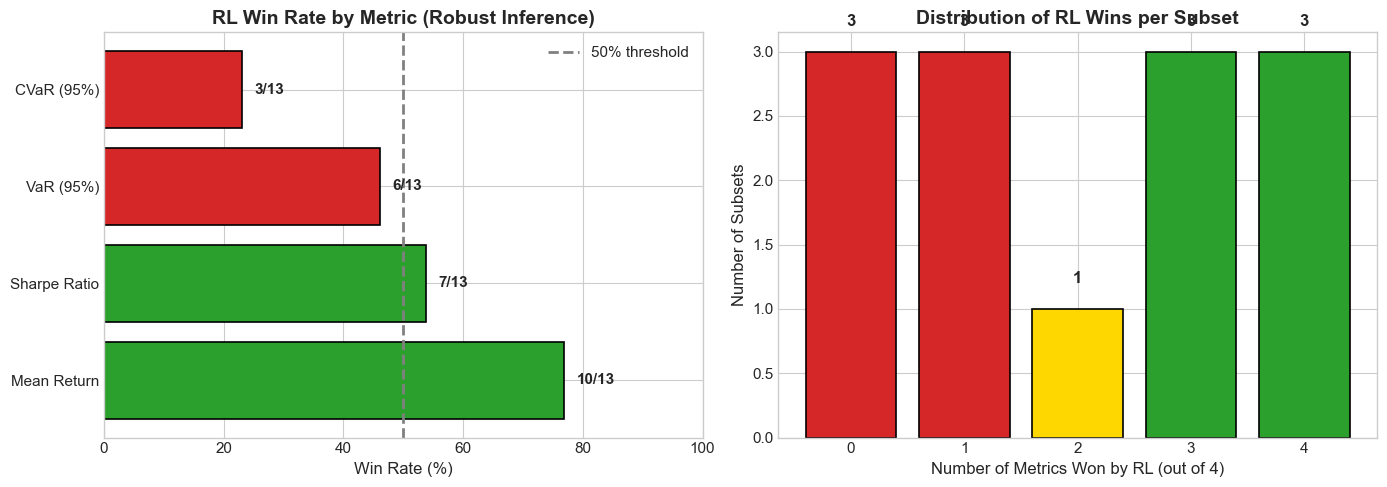

In [27]:
# Win rate by metric - bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: Win rate by metric ---
ax1 = axes[0]
metrics = list(win_counts.keys())
wins = list(win_counts.values())
rates = [w/n_subsets*100 for w in wins]

colors = ['C2' if r >= 50 else 'C3' for r in rates]
bars = ax1.barh(metrics, rates, color=colors, edgecolor='black', linewidth=1.2)
ax1.axvline(50, color='gray', linestyle='--', linewidth=2, label='50% threshold')
ax1.set_xlabel('Win Rate (%)', fontsize=12)
ax1.set_title('RL Win Rate by Metric (Robust Inference)', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 100)

for bar, rate, w in zip(bars, rates, wins):
    ax1.text(rate + 2, bar.get_y() + bar.get_height()/2, f'{w}/{n_subsets}', 
             va='center', fontsize=11, fontweight='bold')

ax1.legend()

# --- Right: Distribution of total wins ---
ax2 = axes[1]
win_dist = valid_results["total_wins"].value_counts().sort_index()
colors2 = ['C3', 'C3', 'gold', 'C2', 'C2']  # 0,1=red, 2=yellow, 3,4=green
ax2.bar(win_dist.index, win_dist.values, color=[colors2[i] for i in win_dist.index], 
        edgecolor='black', linewidth=1.2)
ax2.set_xlabel('Number of Metrics Won by RL (out of 4)', fontsize=12)
ax2.set_ylabel('Number of Subsets', fontsize=12)
ax2.set_title('Distribution of RL Wins per Subset', fontsize=14, fontweight='bold')
ax2.set_xticks([0, 1, 2, 3, 4])

for i, v in zip(win_dist.index, win_dist.values):
    ax2.text(i, v + 0.2, str(v), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 10. Detailed Comparison Table

In [28]:
# Create a detailed comparison table with win indicators
detail_df = valid_results[[
    "subset_name", "n_tickers", 
    "current_mean_return", "rl_mean_return", "rl_wins_return",
    "current_sharpe", "rl_sharpe", "rl_wins_sharpe",
    "total_wins"
]].copy()

# Add win emoji
detail_df["Winner"] = detail_df["total_wins"].apply(
    lambda x: "🏆 RL" if x >= 3 else ("⚖️ Tie" if x == 2 else "📊 Equal-Weight")
)

# Format for display
def highlight_winner(row):
    if row["total_wins"] >= 3:
        return ['background-color: #2ecc71; color: #0b2e13; font-weight: bold'] * len(row)
    elif row["total_wins"] <= 1:
        return ['background-color: #e74c3c; color: white; font-weight: bold'] * len(row)
    else:
        return ['background-color: #f1c40f; color: #3a2f00; font-weight: bold'] * len(row)

styled_df = detail_df.style.apply(highlight_winner, axis=1).format({
    "current_mean_return": "{:.2%}",
    "rl_mean_return": "{:.2%}",
    "current_sharpe": "{:.3f}",
    "rl_sharpe": "{:.3f}",
})

print("Detailed Results (Green=RL wins 3+, Yellow=Tie, Red=Equal-weight wins):")
display(styled_df)

Detailed Results (Green=RL wins 3+, Yellow=Tie, Red=Equal-weight wins):


,subset_name,n_tickers,current_mean_return,rl_mean_return,rl_wins_return,current_sharpe,rl_sharpe,rl_wins_sharpe,total_wins,Winner
0,Banks,5,10.68%,11.94%,True,0.699,0.754,True,4,🏆 RL
1,IT,5,5.21%,6.30%,True,0.451,0.446,False,1,📊 Equal-Weight
2,Pharma,3,9.97%,11.63%,True,0.757,0.809,True,2,⚖️ Tie
3,Consumer,4,12.35%,14.00%,True,1.156,1.193,True,3,🏆 RL
4,Auto,3,5.74%,5.69%,False,0.312,0.304,False,0,📊 Equal-Weight
5,Energy_Infra,4,7.06%,4.73%,False,0.444,0.312,False,0,📊 Equal-Weight
6,Banks_IT,5,12.94%,16.09%,True,0.957,0.996,True,3,🏆 RL
7,Diversified_6,6,4.25%,4.36%,True,0.386,0.369,False,1,📊 Equal-Weight
8,Top_10,10,3.81%,5.18%,True,0.454,0.553,True,3,🏆 RL
9,Small_3,3,0.76%,0.55%,False,0.045,0.033,False,0,📊 Equal-Weight


## 11. Return Improvement Analysis

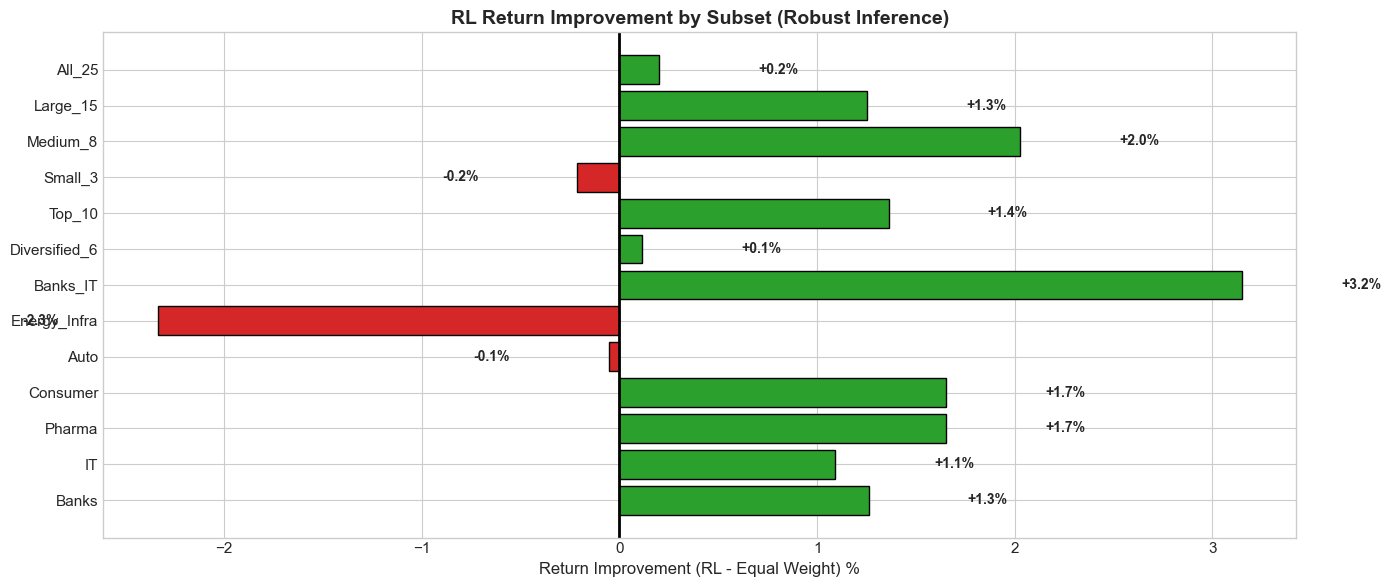


Return Improvement Statistics:
  Mean improvement:   +0.86%
  Median improvement: +1.25%
  Max improvement:    +3.15%
  Min improvement:    -2.34%


In [29]:
# Return improvement bar chart
fig, ax = plt.subplots(figsize=(14, 6))

subset_names = valid_results["subset_name"].values
improvements = valid_results["return_improvement"].values * 100  # Convert to percentage

colors = ['C2' if imp >= 0 else 'C3' for imp in improvements]
bars = ax.barh(subset_names, improvements, color=colors, edgecolor='black', linewidth=1)

ax.axvline(0, color='black', linewidth=2)
ax.set_xlabel('Return Improvement (RL - Equal Weight) %', fontsize=12)
ax.set_title('RL Return Improvement by Subset (Robust Inference)', fontsize=14, fontweight='bold')

# Add value labels
for bar, imp in zip(bars, improvements):
    x_pos = imp + 0.5 if imp >= 0 else imp - 0.5
    ha = 'left' if imp >= 0 else 'right'
    ax.text(x_pos, bar.get_y() + bar.get_height()/2, f'{imp:+.1f}%', 
            va='center', ha=ha, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Stats
print(f"\nReturn Improvement Statistics:")
print(f"  Mean improvement:   {valid_results['return_improvement'].mean()*100:+.2f}%")
print(f"  Median improvement: {valid_results['return_improvement'].median()*100:+.2f}%")
print(f"  Max improvement:    {valid_results['return_improvement'].max()*100:+.2f}%")
print(f"  Min improvement:    {valid_results['return_improvement'].min()*100:+.2f}%")

## 12. Sharpe Ratio Comparison

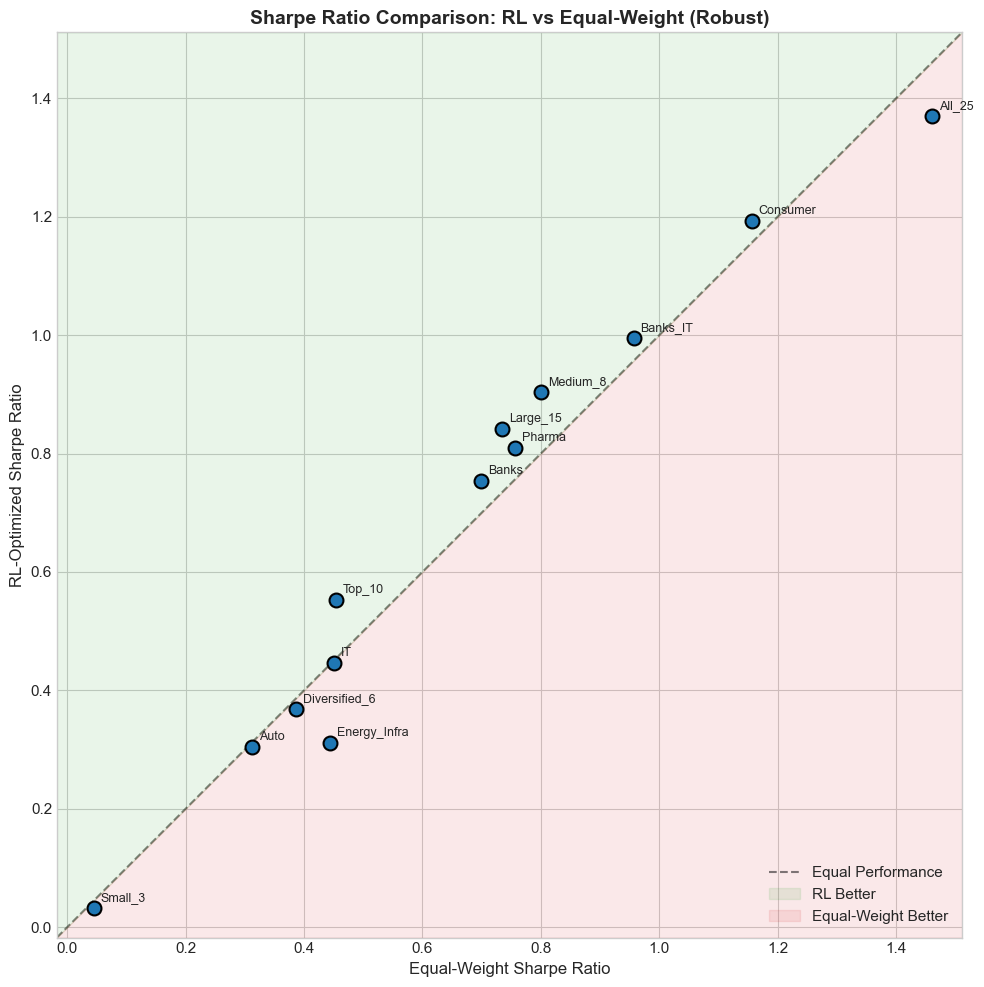

In [30]:
# Sharpe ratio comparison scatter plot
fig, ax = plt.subplots(figsize=(10, 10))

current_sharpe = valid_results["current_sharpe"].values
rl_sharpe = valid_results["rl_sharpe"].values
subset_names = valid_results["subset_name"].values

# Scatter plot
ax.scatter(current_sharpe, rl_sharpe, s=100, c='C0', edgecolors='black', linewidths=1.5, zorder=5)

# Add labels
for i, name in enumerate(subset_names):
    ax.annotate(name, (current_sharpe[i], rl_sharpe[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# Diagonal line (equal performance)
lims = [min(current_sharpe.min(), rl_sharpe.min()) - 0.05,
        max(current_sharpe.max(), rl_sharpe.max()) + 0.05]
ax.plot(lims, lims, 'k--', alpha=0.5, label='Equal Performance', zorder=1)

# Fill regions
ax.fill_between(lims, lims, [lims[1], lims[1]], alpha=0.1, color='C2', label='RL Better')
ax.fill_between(lims, [lims[0], lims[0]], lims, alpha=0.1, color='C3', label='Equal-Weight Better')

ax.set_xlabel('Equal-Weight Sharpe Ratio', fontsize=12)
ax.set_ylabel('RL-Optimized Sharpe Ratio', fontsize=12)
ax.set_title('Sharpe Ratio Comparison: RL vs Equal-Weight (Robust)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## 13. Final Summary

In [31]:
print("=" * 70)
print("          FINAL SUMMARY: RL vs EQUAL-WEIGHT (ROBUST INFERENCE)")
print("=" * 70)

print(f"\n📊 SUBSETS TESTED: {n_subsets}")
print(f"   (Various sector-based and size-based combinations)")

print(f"\n⚙️  ROBUST CONFIG USED:")
print(f"   • Start-step ensemble: {ROBUST_CONFIG['use_start_ensemble']} (offsets: {ROBUST_CONFIG['start_offsets']})")
print(f"   • Last-K smoothing: K={ROBUST_CONFIG['last_k']}")
print(f"   • Cap/Floor: {ROBUST_CONFIG['cap']*100:.0f}% / {ROBUST_CONFIG['floor']*100:.0f}%")
print(f"   • MC paths: {ROBUST_CONFIG['n_paths']}, noise: {ROBUST_CONFIG['noise']}")

print(f"\n🎯 WIN RATES BY METRIC:")
for metric, wins in win_counts.items():
    emoji = "✅" if wins > n_subsets/2 else "❌"
    print(f"   {emoji} {metric}: {wins}/{n_subsets} ({wins/n_subsets:.1%})")

print(f"\n🏆 OVERALL VERDICT:")
total_metric_wins = sum(win_counts.values())
total_metric_tests = n_subsets * 4
overall_win_rate = total_metric_wins / total_metric_tests

print(f"   Total metric wins: {total_metric_wins}/{total_metric_tests} ({overall_win_rate:.1%})")

if overall_win_rate > 0.6:
    verdict = "RL CLEARLY OUTPERFORMS equal-weight allocation"
    emoji = "🚀"
elif overall_win_rate > 0.5:
    verdict = "RL SLIGHTLY OUTPERFORMS equal-weight allocation"
    emoji = "📈"
elif overall_win_rate > 0.4:
    verdict = "MIXED RESULTS - neither clearly dominates"
    emoji = "⚖️"
else:
    verdict = "Equal-weight OUTPERFORMS RL on this data"
    emoji = "📊"

print(f"\n   {emoji} {verdict}")

print(f"\n📈 RETURN IMPROVEMENT:")
print(f"   Average: {valid_results['return_improvement'].mean()*100:+.2f}%")
print(f"   Best:    {valid_results['return_improvement'].max()*100:+.2f}% ({valid_results.loc[valid_results['return_improvement'].idxmax(), 'subset_name']})")
print(f"   Worst:   {valid_results['return_improvement'].min()*100:+.2f}% ({valid_results.loc[valid_results['return_improvement'].idxmin(), 'subset_name']})")

print(f"\n💡 KEY INSIGHTS:")
print(f"   • RL won ALL 4 metrics in {len(rl_dominates)} subset(s): {list(rl_dominates['subset_name'].values) if len(rl_dominates) > 0 else 'None'}")
print(f"   • Equal-weight won 3+ metrics in {len(ew_majority)} subset(s): {list(ew_majority['subset_name'].values) if len(ew_majority) > 0 else 'None'}")

print("\n" + "=" * 70)

          FINAL SUMMARY: RL vs EQUAL-WEIGHT (ROBUST INFERENCE)

📊 SUBSETS TESTED: 13
   (Various sector-based and size-based combinations)

⚙️  ROBUST CONFIG USED:
   • Start-step ensemble: True (offsets: [-4, -3, -2, -1, 0])
   • Last-K smoothing: K=5
   • Cap/Floor: 15% / 2%
   • MC paths: 2000, noise: block_bootstrap

🎯 WIN RATES BY METRIC:
   ✅ Mean Return: 10/13 (76.9%)
   ✅ Sharpe Ratio: 7/13 (53.8%)
   ❌ VaR (95%): 6/13 (46.2%)
   ❌ CVaR (95%): 3/13 (23.1%)

🏆 OVERALL VERDICT:
   Total metric wins: 26/52 (50.0%)

   ⚖️ MIXED RESULTS - neither clearly dominates

📈 RETURN IMPROVEMENT:
   Average: +0.86%
   Best:    +3.15% (Banks_IT)
   Worst:   -2.34% (Energy_Infra)

💡 KEY INSIGHTS:
   • RL won ALL 4 metrics in 3 subset(s): ['Banks', 'Medium_8', 'Large_15']
   • Equal-weight won 3+ metrics in 6 subset(s): ['IT', 'Auto', 'Energy_Infra', 'Diversified_6', 'Small_3', 'All_25']



In [32]:
# Save results to CSV for further analysis
output_path = project_root / "data" / "subset_robust_test_results.csv"
valid_results.to_csv(output_path, index=False)
print(f"✓ Results saved to {output_path}")

✓ Results saved to c:\Users\Atharva Srivastava\Downloads\anndl\data\subset_robust_test_results.csv
